# Import libraries

In [1]:
from utils_experiments import *

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Activation, Dense, Flatten
from keras import initializers
from tensorflow.keras.metrics import R2Score

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import pandas as pd
import time


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

2025-01-18 20:12:21.458102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 20:12:21.529071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-18 20:12:21.554893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 20:12:21.667755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-18 20:12:23.501381: W tensorflow/compiler/tf2

In [2]:
tf.config.list_physical_devices('GPU')

I0000 00:00:1737249146.638314  214718 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737249146.929499  214718 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737249146.929568  214718 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
epochs=100

# Load data

In [4]:
seis_mature= np.load('data/data_decatur/processed/seismic_mature_block.npy')
phi_mature = np.load('data/data_decatur/processed/porosity_mature_block.npy')

seis_exploration = np.load('data/data_decatur/processed/seismic_exploration_block.npy')
phi_exploration = np.load('data/data_decatur/processed/porosity_exploration_block.npy')

phi_mature[phi_mature<0] = 0
phi_exploration[phi_exploration<0] = 0

In [5]:
well_seismic_data = np.load('data/data_decatur/processed/well_seismic.npy')
well_porosity_data = np.load('data/data_decatur/processed/well_porosity.npy')

well_seismic_data = scale_to_range(well_seismic_data)
well_porosity_data = scale_to_range(well_porosity_data)

In [6]:
well_seismic_data.shape, well_seismic_data.min(), well_seismic_data.max(), well_porosity_data.shape, well_porosity_data.min(), well_porosity_data.max()

((2, 86, 1, 1), -1.0, 1.0, (2, 86, 1, 1), -1.0, 1.0)

In [7]:
print(phi_exploration.shape)

(143, 370, 86)


In [8]:
depth_start = 4700
depth_end = 6410
depth_step = 20
depth_values = np.arange(depth_start, depth_end , depth_step)
num_ticks = 6 
depth_indices = np.linspace(0, len(depth_values) - 1, num_ticks, dtype=int)

inline_number = 83

# MLP

In [9]:
X_train_nn = seis_mature.reshape(-1, 86)
y_train_nn = phi_mature.reshape(-1, 86)

In [10]:
y_train_nn.shape

(120263, 86)

## Architecture

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, activation='tanh',input_shape=(86,)),
  tf.keras.layers.Dense(100, activation='tanh'),
  tf.keras.layers.Dense(100, activation='tanh'),
  tf.keras.layers.Dense(100, activation='tanh'),
  tf.keras.layers.Dense(86, activation='tanh'),
])
model.summary()

/home/nicolas/datascience/2024_tesis_maestria/.tesisenv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737249147.258457  214718 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737249147.258672  214718 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737249147.258726  214718 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737249147.658093  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         8,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 86)             │         8,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,686 (186.27 KB)

 Trainable params: 47,686 (186.27 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='adam',
                    loss='mse',
                    metrics=[R2Score()])

In [13]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/first_nn.weights.h5', 
                                                monitor='r2_score', 
                                                mode='max', 
                                                verbose=1, 
                                                save_weights_only=True)

callback_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='r2_score', 
                                                   factor=0.5, 
                                                   patience=10, 
                                                   min_lr=0.0001)

## Training

In [14]:
start_time = time.time()

history_nn = model.fit(X_train_nn, 
                       y_train_nn,
                       validation_split=0.2,
                       epochs=epochs,
                       batch_size=512,
                        callbacks=[checkpoint, callback_lr] )
end_time = time.time()
training_time_MLP = end_time - start_time

Epoch 1/100


I0000 00:00:1737249151.604929  214787 service.cc:146] XLA service 0x7fbf8800d500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737249151.605144  214787 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-01-18 20:12:31.639998: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-18 20:12:31.877718: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 42/188 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0694 - r2_score: -723.4522

I0000 00:00:1737249153.144228  214787 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0294 - r2_score: -305.2048
Epoch 1: saving model to models/first_nn.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0293 - r2_score: -304.1465 - val_loss: 0.0117 - val_r2_score: -111.2656 - learning_rate: 0.0010
Epoch 2/100
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7837e-04 - r2_score: -6.1760
Epoch 2: saving model to models/first_nn.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7673e-04 - r2_score: -6.1590 - val_loss: 0.0088 - val_r2_score: -80.2584 - learning_rate: 0.0010
Epoch 3/100
180/188 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6673e-04 - r2_score: -1.9350
Epoch 3: saving model to models/first_nn.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6494e-04 - r2_score: -1.9173 - val_loss: 0.0081 - val_r2_score: -73.3641 - learning_rate: 0.0010
Epoch 4/100
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4908e-04 - r2_score: -0.7763
Epoch 4: saving model to models/first_nn.weig

In [15]:
history_nn.history.keys()

dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score', 'learning_rate'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


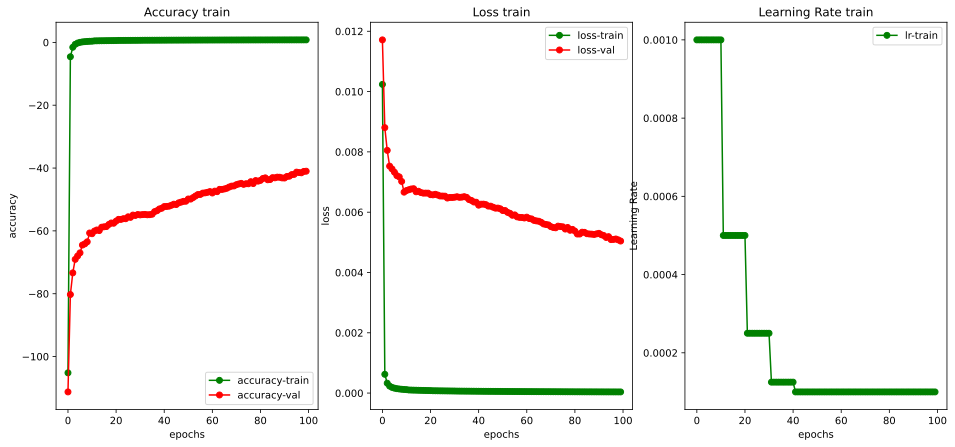

In [16]:
epochs_for_plot = [i for i in range(epochs)]

train_acc = history_nn.history['r2_score']
train_loss = history_nn.history['loss']
train_lr = history_nn.history['learning_rate']
val_acc = history_nn.history['val_r2_score']
val_loss = history_nn.history['val_loss']

fig, ax = plt.subplots(1,3)
fig.set_size_inches(16,7)

ax[0].plot(epochs_for_plot, train_acc, 'go-', label='accuracy-train')
ax[0].plot(epochs_for_plot, val_acc, 'ro-', label='accuracy-val')
ax[0].set_title('Accuracy train')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')
#ax[0].set_ylim(0,1)

ax[1].plot(epochs_for_plot, train_loss, 'go-', label='loss-train')
ax[1].plot(epochs_for_plot, val_loss, 'ro-', label='loss-val')
ax[1].set_title('Loss train')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')

ax[2].plot(epochs_for_plot, train_lr, 'go-', label='lr-train')
ax[2].set_title('Learning Rate train')
ax[2].legend()
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Learning Rate')

fig.savefig('./plots/nn_training_real_data.eps')

plt.show()

## Metrics

In [17]:
y_pred_nn_train = model.predict(X_train_nn)

3759/3759 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [18]:
rmse_nn_train = np.sqrt(mean_squared_error(y_train_nn, y_pred_nn_train))
MAE_nn_train = mean_absolute_error(y_train_nn, y_pred_nn_train)
r2_nn_train = r2_score(y_train_nn, y_pred_nn_train)

print("RMSE : % f" %(rmse_nn_train))
print("MAE : % f" %(MAE_nn_train))
print("R2 : % f" %(r2_nn_train))

RMSE :  0.032243
MAE :  0.012015
R2 : -3.780085


In [19]:
X_test_nn = seis_exploration.reshape(-1, 86)
y_test_nn = phi_exploration.reshape(-1, 86)

In [20]:
y_pred_nn = model.predict(X_test_nn)


1654/1654 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [21]:
loss, accuracy = model.evaluate(X_test_nn, y_test_nn)

1654/1654 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.3811e-04 - r2_score: -6.4748


In [22]:
rmse_nn = np.sqrt(mean_squared_error(y_test_nn, y_pred_nn))
MAE_nn = mean_absolute_error(y_test_nn, y_pred_nn)
r2_nn = r2_score(y_test_nn, y_pred_nn)

print("RMSE : % f" %(rmse_nn))
print("MAE : % f" %(MAE_nn))
print("R2 : % f" %(r2_nn))

RMSE :  0.045561
MAE :  0.026629
R2 : -6.841576


## Plotting

In [23]:
y_test_nn = y_test_nn.reshape(143,370,86)
y_pred_nn = y_pred_nn.reshape(143,370,86)

In [24]:
phi_difference_nn = y_pred_nn - phi_exploration

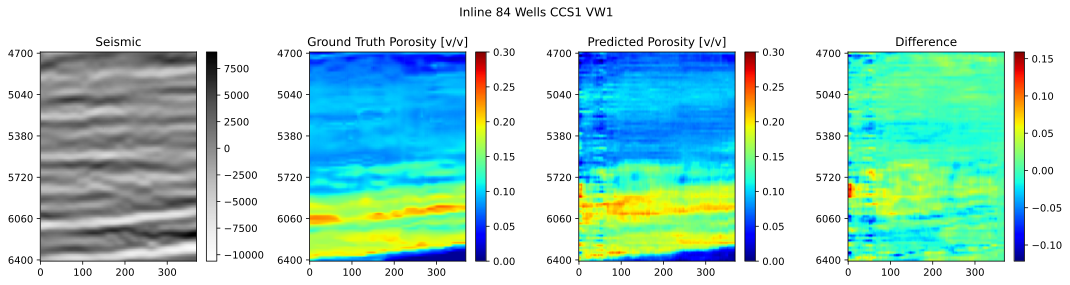

In [25]:
fig, ax = plt.subplots(1,4, figsize = (15, 4))

fig.suptitle('Inline 84 Wells CCS1 VW1')

im1 = ax[0].imshow(seis_exploration[inline_number-40,:,:].T, cmap='Greys')
ax[0].set_title('Seismic')
ax[0].set_aspect('auto')
ax[0].set_yticks(depth_indices)
ax[0].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im1, ax=ax[0], shrink=1)

im2 = ax[1].imshow(phi_exploration[inline_number-40,:,:].T, vmin=0, vmax=0.3, cmap='jet')
ax[1].set_title('Ground Truth Porosity [v/v]')
ax[1].set_aspect('auto')
ax[1].set_yticks(depth_indices)
ax[1].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im2, ax=ax[1], shrink=1)

im3 = ax[2].imshow(y_pred_nn[inline_number-40,:,:].T, vmin=0, vmax=0.3, cmap='jet')
ax[2].set_title('Predicted Porosity [v/v]')
ax[2].set_aspect('auto')
ax[2].set_yticks(depth_indices)
ax[2].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im3, ax=ax[2], shrink=1)


im4 = ax[3].imshow(phi_difference_nn[inline_number-40,:,:].T, cmap='jet')
ax[3].set_title('Difference')
ax[3].set_aspect('auto')
ax[3].set_yticks(depth_indices)
ax[3].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im4, ax=ax[3], shrink=1)

fig.tight_layout()
fig.savefig("./plots/nn_exploration_inline.eps", format="eps", bbox_inches="tight")

plt.show()

# CNN

In [26]:
phi_max=np.max(phi_mature)
phi_min=np.min(phi_mature)

In [27]:
seis_normalized = (seis_mature - np.min(seis_mature))/(np.max(seis_mature)-np.min(seis_mature))
y_train_norm = scale_to_range(phi_mature)

In [28]:
X_train_final_cnn = seis_normalized.reshape(-1, 86, 1)
y_train_norm = y_train_norm.reshape(-1, 86)

In [29]:
y_train_norm.shape, X_train_final_cnn.shape

((120263, 86), (120263, 86, 1))

In [30]:
y_train_norm.min(), y_train_norm.max(), X_train_final_cnn.min(), X_train_final_cnn.max()

(-1.0, 1.0, 0.0, 1.0)

### Architecture

In [31]:
given_seed = 13
def naive_model():

    model_phi = tf.keras.models.Sequential()
    
    model_phi.add(Conv1D(input_shape=(86,1), filters=32, kernel_size=2, strides=2, padding='same',kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')) 
    model_phi.add(Activation('relu'))
    
    model_phi.add(Conv1D(filters=64, kernel_size=7, strides=2, padding='same',kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')) 
    model_phi.add(Activation('relu'))
    
    model_phi.add(Conv1D(filters=128, kernel_size=15, strides=2, padding='same',kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')) 
    model_phi.add(Activation('relu'))
    
    model_phi.add(Conv1D(filters=256, kernel_size=30, strides=2, padding='same',kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')) 
    model_phi.add(Activation('relu'))
    
    model_phi.add(tf.keras.layers.Dropout(rate=0.3))
    

    model_phi.add(Flatten())
 
    
    model_phi.add(Dense(units=86,kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros'))
    model_phi.add(Activation('tanh'))

    return model_phi
model_phi = naive_model()
model_phi.summary()

/home/nicolas/datascience/2024_tesis_maestria/.tesisenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 43, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 43, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 64)         │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 128)        │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6, 256)         │       983,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 86)             │       132,182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 86)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,252,982 (4.78 MB)

 Trainable params: 1,252,982 (4.78 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model_phi.compile(optimizer='adam',
                    loss='mse',
                    metrics=[R2Score()])

In [33]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/first_cnn.weights.h5', 
                                                monitor='r2_score', 
                                                mode='max', 
                                                verbose=1, 
                                                save_weights_only=True)

callback_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='r2_score', 
                                                   factor=0.5, 
                                                   patience=10, 
                                                   min_lr=0.0001)

### Training

In [34]:
start_time = time.time()
history_early = model_phi.fit(x=X_train_final_cnn, 
                              y=y_train_norm,
                              validation_split=0.2,
                              epochs=epochs,
                              batch_size=512,
                              callbacks=[checkpoint, callback_lr]
                              )
end_time = time.time()
training_time_CNN = end_time - start_time

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0243 - r2_score: -1.7898
Epoch 1: saving model to models/first_cnn.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - loss: 0.0242 - r2_score: -1.7802 - val_loss: 0.0143 - val_r2_score: -0.2316 - learning_rate: 0.0010
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0030 - r2_score: 0.7222
Epoch 2: saving model to models/first_cnn.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0030 - r2_score: 0.7223 - val_loss: 0.0137 - val_r2_score: -0.2132 - learning_rate: 0.0010
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0022 - r2_score: 0.7940
Epoch 3: saving model to models/first_cnn.weights.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0022 - r2_score: 0.7941 - val_loss: 0.0138 - val_r2_score: -0.1764 - learning_rate: 0.0010
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0018 - r2_score: 0.8273
Epoch 4: saving model to models/first_cnn.weights.h5
18

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


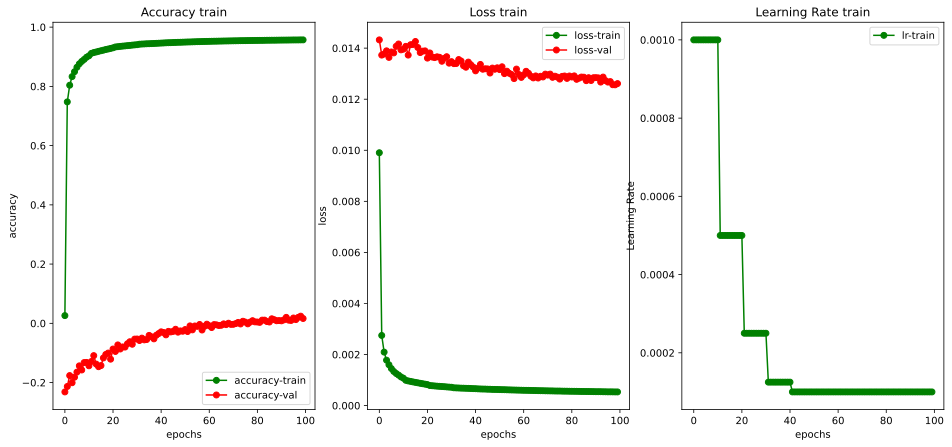

In [35]:
epochs = [i for i in range(epochs)]

train_acc = history_early.history['r2_score']
train_loss = history_early.history['loss']
train_lr = history_early.history['learning_rate']
val_acc = history_early.history['val_r2_score']
val_loss = history_early.history['val_loss']


fig, ax = plt.subplots(1,3)
fig.set_size_inches(16,7)

ax[0].plot(epochs, train_acc, 'go-', label='accuracy-train')
ax[0].plot(epochs, val_acc, 'ro-', label='accuracy-val')
ax[0].set_title('Accuracy train')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')
#ax[0].set_ylim(0,1)

ax[1].plot(epochs, train_loss, 'go-', label='loss-train')
ax[1].plot(epochs, val_loss, 'ro-', label='loss-val')
ax[1].set_title('Loss train')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')

ax[2].plot(epochs, train_lr, 'go-', label='lr-train')
ax[2].set_title('Learning Rate train')
ax[2].legend()
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Learning Rate')

fig.savefig('./plots/cnn_training_real_data.eps')

plt.show()

## Metrics

In [36]:
y_pred_cnn_train = model_phi.predict(X_train_final_cnn)

3759/3759 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


In [37]:
rmse_cnn_train = np.sqrt(mean_squared_error(y_train_norm, y_pred_cnn_train))
MAE_cnn_train = mean_absolute_error(y_train_norm, y_pred_cnn_train)
r2_cnn_train = r2_score(y_train_norm, y_pred_cnn_train)

print("RMSE : % f" %(rmse_cnn_train))
print("MAE : % f" %(MAE_cnn_train))
print("R2 : % f" %(r2_cnn_train))

RMSE :  0.051591
MAE :  0.021608
R2 :  0.866896


In [38]:
phi_max_test=np.max(phi_exploration)
phi_min_test =np.min(phi_exploration)

In [39]:
seis_norm_expl = (seis_exploration - np.min(seis_exploration))/(np.max(seis_exploration)-np.min(seis_exploration))
y_expl_norm = scale_to_range(phi_exploration, min_val= -1, max_val=1)

In [40]:
X_test_final_cnn = seis_norm_expl.reshape(-1, 86,1)
y_expl_norm_cnn = y_expl_norm.reshape(-1, 86)

In [41]:
y_expl_norm_cnn.shape, X_test_final_cnn.shape

((52910, 86), (52910, 86, 1))

In [42]:
y_train_norm.min(), y_train_norm.max(), X_train_final_cnn.min(), X_train_final_cnn.max()

(-1.0, 1.0, 0.0, 1.0)

In [43]:
y_pred_cnn = model_phi.predict(X_test_final_cnn)

1654/1654 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [44]:
loss, accuracy = model_phi.evaluate(X_test_final_cnn, y_expl_norm_cnn)

1654/1654 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0174 - r2_score: -0.1710


In [45]:
rmse_cnn = np.sqrt(mean_squared_error(y_expl_norm_cnn, y_pred_cnn))
MAE_cnn = mean_absolute_error(y_expl_norm_cnn, y_pred_cnn)
r2_cnn = r2_score(y_expl_norm_cnn, y_pred_cnn)

print("RMSE : % f" %(rmse_cnn))
print("MAE : % f" %(MAE_cnn))
print("R2 : % f" %(r2_cnn))

RMSE :  0.135037
MAE :  0.095799
R2 :  0.213759


## Plotting

In [46]:
y_expl_norm_cnn = unscale_from_range(y_expl_norm_cnn, original_min= phi_min_test, original_max=phi_max_test)
y_pred_cnn = unscale_from_range(y_pred_cnn, original_min= phi_min_test, original_max=phi_max_test)

In [47]:
y_expl_norm_cnn = y_expl_norm_cnn.reshape(143,370,86)
y_pred_cnn = y_pred_cnn.reshape(143,370,86)

In [48]:
phi_difference_cnn =  y_pred_cnn - y_expl_norm_cnn

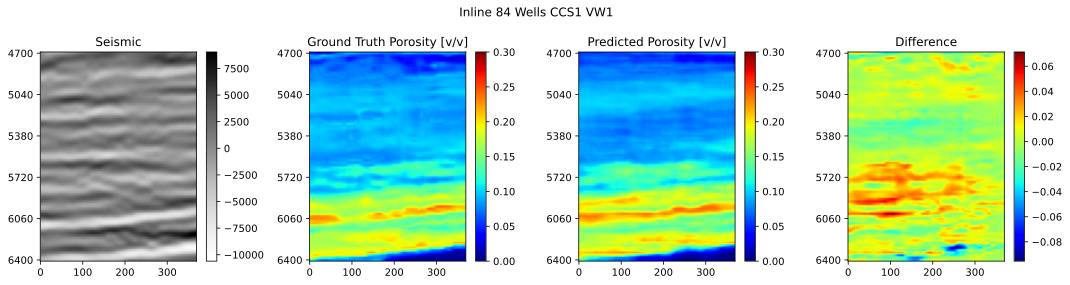

In [49]:
fig, ax = plt.subplots(1,4, figsize = (15, 4))

fig.suptitle('Inline 84 Wells CCS1 VW1')

im1 = ax[0].imshow(seis_exploration[inline_number-40,:,:].T, cmap='Greys')
ax[0].set_title('Seismic')
ax[0].set_aspect('auto')
ax[0].set_yticks(depth_indices)
ax[0].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im1, ax=ax[0], shrink=1)

im2 = ax[1].imshow(y_expl_norm_cnn[inline_number-40,:,:].T, vmin=0, vmax=0.3, cmap='jet')
ax[1].set_title('Ground Truth Porosity [v/v]')
ax[1].set_aspect('auto')
ax[1].set_yticks(depth_indices)
ax[1].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im2, ax=ax[1], shrink=1)

im3 = ax[2].imshow(y_pred_cnn[inline_number-40,:,:].T, vmin=0, vmax=0.3, cmap='jet')
ax[2].set_title('Predicted Porosity [v/v]')
ax[2].set_aspect('auto')
ax[2].set_yticks(depth_indices)
ax[2].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im3, ax=ax[2], shrink=1)

im4 = ax[3].imshow(phi_difference_cnn[inline_number-40,:,:].T, cmap='jet')
ax[3].set_title('Difference')
ax[3].set_aspect('auto')
ax[3].set_yticks(depth_indices)
ax[3].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im4, ax=ax[3], shrink=1)

fig.tight_layout()
fig.savefig("./plots/cnn_exploration_inline.eps", format="eps", bbox_inches="tight")

plt.show()

# CNN Propia

## Custom Functions

In [50]:
def r2_score(y_true, y_pred):
    """
    Calculate R² score using Keras backend operations.
    
    Parameters:
    -----------
    y_true : tensor
        Ground truth values
    y_pred : tensor
        Predicted values
        
    Returns:
    --------
    tensor
        R² score
    """
    # Convert inputs to tensors if they aren't already
    
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    
    ss_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + K.epsilon())  # Para evitar divisiones por cero

In [51]:


class CustomSeismicLoss(tf.keras.losses.Loss):
    def __init__(self,
                 model,  # The neural network model
                 well_seismic_data,  # Seismic data at well locations S_w
                 well_porosity_data,  # Observed porosity at well locations φ_w
                 lambda_param=0.5,
                 name='custom_seismic_loss'):
        """
        Custom loss function for seismic to porosity mapping.
        
        Args:
            model (tf.keras.Model): Neural network model to predict porosity
            well_seismic_data (tf.Tensor): Seismic data at well locations S_w
            well_porosity_data (tf.Tensor): Observed porosity at well locations φ_w
            lambda_param (float): Regularization parameter
            name (str): Name of the loss function
        """
        super().__init__(name=name)
        self.model = model
        self.well_seismic_data = tf.convert_to_tensor(well_seismic_data, dtype=tf.float32)
        self.well_porosity_data = tf.convert_to_tensor(well_porosity_data, dtype=tf.float32)
        self.lambda_param = lambda_param
    
    def call(self, y_true, y_pred):
        """
        Compute the custom loss.
        
        Args:
            y_true (tf.Tensor): Actual porosity values
            y_pred (tf.Tensor): Predicted porosity values
        
        Returns:
            tf.Tensor: Computed loss value
        """
        # First term: L2 norm of prediction error for full dataset
        first_term = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # Second term: Predict porosity using well seismic data and compare with well porosity
        y_pred_well = self.model(self.well_seismic_data, training=False)
        second_term = (self.lambda_param / 2) * tf.reduce_mean(tf.square(self.well_porosity_data - y_pred_well ))
        
        # Total loss is the sum of both terms
        total_loss = first_term + second_term
        
        return total_loss


class LearningRateSchedulerOnR2(tf.keras.callbacks.Callback):
    def __init__(self, patience=5, factor=0.5, min_lr=1e-6):
        super().__init__()
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.r2_scores = []
        self.consecutive_decrease_count = 0

    def on_epoch_end(self, epoch, logs=None):
        r2_score = logs.get('val_r2_score')
        if r2_score is None:
            print("R2 score is not logged; skipping learning rate adjustment.")
            return
        
        self.r2_scores.append(r2_score)
        
        if len(self.r2_scores) > 1:
            if r2_score < self.r2_scores[-2]:
                self.consecutive_decrease_count += 1
            else:
                self.consecutive_decrease_count = 0
            
        if self.consecutive_decrease_count >= self.patience:
            try:
                # Retrieve the old learning rate
                old_lr = float(self.model.optimizer.learning_rate.numpy())
                print(f"Old learning rate: {old_lr:.6f}")

                # Compute the new learning rate
                new_lr = max(old_lr * self.factor, self.min_lr)
                print(f"Computed new learning rate: {new_lr}, type: {type(new_lr)}")

                # Safely update the learning rate
                self.model.optimizer.learning_rate.assign(new_lr)
                print(f"Learning rate successfully updated to: {new_lr:.6f}")

                self.consecutive_decrease_count = 0  # Reset counter
            except Exception as e:
                print(f"Error during learning rate adjustment: {e}")
                print(f"Learning rate object: {self.model.optimizer.learning_rate}, type: {type(self.model.optimizer.learning_rate)}")
                raise


        
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1}: R2 score: {r2_score:.4f}, Learning rate: {current_lr:.6f}")




class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        # Retrieve the current learning rate and store it
        current_lr = float(self.model.optimizer.learning_rate.numpy())
        self.learning_rates.append(current_lr)
        print(f"Learning rate for epoch {epoch+1}: {current_lr:.6f}")


## Data Wrangling

In [52]:
X_own_cnn = seis_mature.reshape(-1,86,1,1)
Y_own_cnn = phi_mature.reshape(-1,86,1,1)

X_test_own_cnn = seis_exploration.reshape(-1,86,1,1)
Y_test_own_cnn = phi_exploration.reshape(-1,86,1,1)

In [53]:
X_own_cnn_norm = scale_to_range(X_own_cnn)
Y_own_cnn_norm = scale_to_range(Y_own_cnn)

X_test_own_cnn_norm = scale_to_range(X_test_own_cnn)
Y_test_own_cnn_norm = scale_to_range(Y_test_own_cnn)

In [54]:
X_own_cnn_norm.shape, X_own_cnn_norm.min(), X_own_cnn_norm.max()

((120263, 86, 1, 1), -1.0, 1.0)

In [55]:
Y_own_cnn_norm.shape, Y_own_cnn_norm.min(), Y_own_cnn_norm.max()

((120263, 86, 1, 1), -1.0, 1.0)

## Architecture

In [56]:
def simplified_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    # Bloque 1
    x1 = tf.keras.layers.Conv2D(6, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(inputs)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)

    
    # Bloque 2
    x2 = tf.keras.layers.Conv2D(12, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x1)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    
    # Output shape: (124, 1, 12)
    drop = tf.keras.layers.Dropout(0.5)(x2)  # 50% of neurons are randomly dropped during training
    
    flat_bottle_neck = tf.keras.layers.Flatten()(drop)
    dense_bottle_neck = tf.keras.layers.Dense(1032, activation='leaky_relu')(flat_bottle_neck)
    reshape_bottleneck = tf.keras.layers.Reshape((86, 1, 12))(dense_bottle_neck)
    
    # Bloque 3
    x3 = tf.keras.layers.Conv2D(24, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(reshape_bottleneck)
    x3 = tf.keras.layers.LeakyReLU()(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)

    
    # Bloque 4
    x4 = tf.keras.layers.Conv2D(30, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x3)
    x4 = tf.keras.layers.LeakyReLU()(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)

    
    x4 = tf.keras.layers.Conv2D(1, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x4)
    x4 = tf.keras.layers.LeakyReLU()(x4)
    outputs = tf.keras.layers.BatchNormalization()(x4)

    
    model = tf.keras.Model(inputs, outputs)
    return model

# Definir las dimensiones de entrada
input_shape = (86, 1, 1)
# Crear el modelo
model_own = simplified_cnn(input_shape)
print(model_own.summary())

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 86, 1, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 86, 1, 6)       │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 86, 1, 6)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 86, 1, 6)       │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 86, 1, 12)      │           372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 86, 1, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 86, 1, 12)      │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 86, 1, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1032)           │     1,066,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 86, 1, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 86, 1, 24)      │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 86, 1, 24)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 86, 1, 24)      │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 86, 1, 30)      │         3,630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 86, 1, 30)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 86, 1, 30)      │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 86, 1, 1)       │           151 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 86, 1, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 86, 1, 1)       │             4 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,001 (4.09 MB)

 Trainable params: 1,071,855 (4.09 MB)

 Non-trainable params: 146 (584.00 B)

None


## Training

In [57]:
custom_loss = CustomSeismicLoss(
    model_own,
    well_seismic_data, 
    well_porosity_data, 
    lambda_param=0.1
)

initial_lr = 0.001
model_own.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), 
                    loss=custom_loss, 
                    metrics=['mae', r2_score])  

# Define callbacks for this fold
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'models/training_NFE.weights.h5',
    save_weights_only=True,
    verbose=1
)

lr_scheduler = LearningRateSchedulerOnR2(patience=1, factor=0.8, min_lr=1e-6)

lr_logger = LearningRateLogger()

pos = np.random.permutation(Y_own_cnn_norm.shape[0])

start_time = time.time()
# Train the model
history_own = model_own.fit(
    X_own_cnn_norm[pos], Y_own_cnn_norm[pos],
    validation_split=0.2,  # 20% used for validation
    epochs=200, 
    batch_size=512, 
    shuffle=True,
    callbacks=[checkpoint, lr_logger, lr_scheduler]
)
end_time = time.time()
training_time_CNN_own = end_time - start_time

Epoch 1/200


2025-01-18 20:33:49.050681: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.2765 - mae: 0.5193 - r2_score: -2.3677

2025-01-18 20:34:01.265846: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.2692 - mae: 0.5191 - r2_score: -2.3637

2025-01-18 20:34:06.169306: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_transpose_fusion_5', 16 bytes spill stores, 16 bytes spill loads




Epoch 1: saving model to models/training_NFE.weights.h5
Learning rate for epoch 1: 0.001000
Epoch 1: R2 score: -0.0842, Learning rate: 0.001000
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - loss: 3.2619 - mae: 0.5189 - r2_score: -2.3598 - val_loss: 0.2645 - val_mae: 0.2755 - val_r2_score: -0.0842
Epoch 2/200
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4081 - mae: 0.3917 - r2_score: -0.6972
Epoch 2: saving model to models/training_NFE.weights.h5
Learning rate for epoch 2: 0.001000
Epoch 2: R2 score: 0.3395, Learning rate: 0.001000
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.4072 - mae: 0.3911 - r2_score: -0.6926 - val_loss: 0.1808 - val_mae: 0.2051 - val_r2_score: 0.3395
Epoch 3/200
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0794 - mae: 0.0698 - r2_score: 0.9270
Epoch 3: saving model to models/training_NFE.weights.h5
Learning rate for epoch 3: 0.001000
Epoch 3: R2 score: 0.6872, Learning rate: 0.001000
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0793 - m

In [58]:
print(history_own.history.keys())

dict_keys(['loss', 'mae', 'r2_score', 'val_loss', 'val_mae', 'val_r2_score'])


## Metrics

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


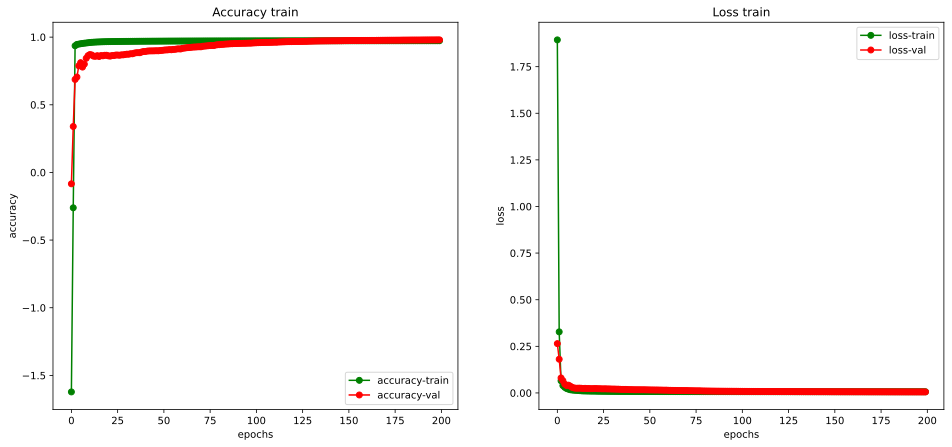

In [59]:
epochs_for_plot = [i for i in range(200)]

train_acc = history_own.history['r2_score']
train_loss = history_own.history['loss']
val_acc = history_own.history['val_r2_score']
val_loss = history_own.history['val_loss']

fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,7)

ax[0].plot(epochs_for_plot, train_acc, 'go-', label='accuracy-train')
ax[0].plot(epochs_for_plot, val_acc, 'ro-', label='accuracy-val')
ax[0].set_title('Accuracy train')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')

ax[1].plot(epochs_for_plot, train_loss, 'go-', label='loss-train')
ax[1].plot(epochs_for_plot, val_loss, 'ro-', label='loss-val')
ax[1].set_title('Loss train')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')

fig.savefig('./plots/cnn_own_training_real_data.eps')

plt.show()

In [60]:
y_pred_cnn_own_train = model_own.predict(X_own_cnn_norm)

3759/3759 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


In [61]:
y_pred_cnn_own_train = np.squeeze(y_pred_cnn_own_train)

In [62]:
Y_own_cnn_norm = np.squeeze(Y_own_cnn_norm)

In [63]:
rmse_own_cnn_train = np.sqrt(mean_squared_error(Y_own_cnn_norm, y_pred_cnn_own_train))
MAE_own_cnn_train = mean_absolute_error(Y_own_cnn_norm, y_pred_cnn_own_train)
r2_own_cnn_train = r2_score(Y_own_cnn_norm, y_pred_cnn_own_train)

print("RMSE : % f" %(rmse_own_cnn_train))
print("MAE : % f" %(MAE_own_cnn_train))
print("R2 : % f" %(r2_own_cnn_train))

RMSE :  0.051749
MAE :  0.034573
R2 :  0.979561


In [64]:
loss, mae, accuracy = model_own.evaluate(X_test_own_cnn_norm, Y_test_own_cnn_norm)

1654/1654 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0207 - mae: 0.0955 - r2_score: 0.8500


In [65]:
y_pred_cnn_own = model_own.predict(X_test_own_cnn_norm)

1654/1654 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [66]:
Y_test_own_cnn_norm = np.squeeze(Y_test_own_cnn_norm)
y_pred_cnn_own = np.squeeze(y_pred_cnn_own)

In [67]:
Y_test_own_cnn_norm.shape, y_pred_cnn_own.shape

((52910, 86), (52910, 86))

In [68]:
rmse_own_cnn = np.sqrt(mean_squared_error(Y_test_own_cnn_norm, y_pred_cnn_own))
MAE_own_cnn = mean_absolute_error(Y_test_own_cnn_norm, y_pred_cnn_own)
r2_own_cnn = r2_score(Y_test_own_cnn_norm, y_pred_cnn_own)

print("RMSE : % f" %(rmse_own_cnn))
print("MAE : % f" %(MAE_own_cnn))
print("R2 : % f" %(r2_own_cnn))

RMSE :  0.134065
MAE :  0.093686
R2 :  0.857028


## Plotting

In [69]:
y_pred_cnn_own_unscaled = unscale_from_range(y_pred_cnn_own, original_min= Y_test_own_cnn.min(), original_max=Y_test_own_cnn.max())

In [70]:
y_pred_cnn_own_unscaled = y_pred_cnn_own_unscaled.reshape(143,370,86)

In [71]:
phi_difference_explo = y_pred_cnn_own_unscaled - phi_exploration

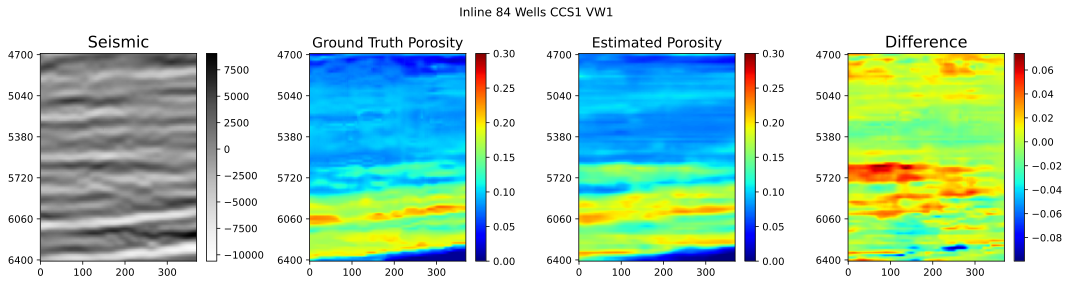

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (15, 4))

fig.suptitle('Inline 84 Wells CCS1 VW1')

im1 = ax[0].imshow(seis_exploration[inline_number-40,:,:].T, cmap='Greys')
ax[0].set_title('Seismic',fontsize = 16)
ax[0].set_aspect('auto')
ax[0].set_yticks(depth_indices)
ax[0].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im1, ax=ax[0], shrink=1)

im2 = ax[1].imshow(phi_exploration[inline_number-40,:,:].T, vmin=0, vmax=0.3, cmap='jet')
ax[1].set_title('Ground Truth Porosity',fontsize = 14)
ax[1].set_aspect('auto')
ax[1].set_yticks(depth_indices)
ax[1].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im2, ax=ax[1], shrink=1)

im3 = ax[2].imshow(y_pred_cnn_own_unscaled[inline_number-40,:,:].T, vmin=0, vmax=0.3, cmap='jet')
ax[2].set_title('Predicted Porosity',fontsize = 14)
ax[2].set_aspect('auto')
ax[2].set_yticks(depth_indices)
ax[2].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im3, ax=ax[2], shrink=1)


im4 = ax[3].imshow(phi_difference_explo[inline_number-40,:,:].T, cmap='jet')
ax[3].set_title('Difference',fontsize = 16)
ax[3].set_aspect('auto')
ax[3].set_yticks(depth_indices)
ax[3].set_yticklabels(depth_values[depth_indices])
fig.colorbar(im4, ax=ax[3], shrink=1)

fig.tight_layout()
fig.savefig("./plots/cnn_own_exploration_inline.eps", format="eps", bbox_inches="tight")

plt.show()

# Compiled Results

In [73]:
compilted_results = {'Method': ['MLP', 'CNN', 'CNN-MLP'],
            'R-Squared Train':[r2_nn_train, r2_cnn_train, r2_own_cnn_train],
            'R-Squared Test':[r2_nn, r2_cnn, r2_own_cnn],
            'MSE Train':[rmse_nn_train, rmse_cnn_train, rmse_own_cnn_train],
            'MSE Test':[rmse_nn, rmse_cnn, rmse_own_cnn],
            'MAE Train':[MAE_nn_train, MAE_cnn_train, MAE_own_cnn_train],
            'MAE Test':[MAE_nn, MAE_cnn, MAE_own_cnn],
            'Time': [training_time_MLP, training_time_CNN, training_time_CNN_own]
          }

df_ml_techniques = pd.DataFrame(data=compilted_results)
df_ml_techniques

,Method,R-Squared Train,R-Squared Test,MSE Train,MSE Test,MAE Train,MAE Test,Time
0,MLP,-3.780085,-6.841576,0.032243,0.045561,0.012015,0.026629,88.146707
1,CNN,0.866896,0.213759,0.051591,0.135037,0.021608,0.095799,1130.129997
2,CNN-MLP,"tf.Tensor(0.9795614, shape=(), dtype=float32)","tf.Tensor(0.857028, shape=(), dtype=float32)",0.051749,0.134065,0.034573,0.093686,737.328105


In [74]:
latex_table = df_ml_techniques.to_latex(index=False, float_format="%.3f")

print(latex_table)

\begin{tabular}{lllrrrrr}
\toprule
Method & R-Squared Train & R-Squared Test & MSE Train & MSE Test & MAE Train & MAE Test & Time \\
\midrule
MLP & -3.780 & -6.842 & 0.032 & 0.046 & 0.012 & 0.027 & 88.147 \\
CNN & 0.867 & 0.214 & 0.052 & 0.135 & 0.022 & 0.096 & 1130.130 \\
CNN-MLP & tf.Tensor(0.9795614, shape=(), dtype=float32) & tf.Tensor(0.857028, shape=(), dtype=float32) & 0.052 & 0.134 & 0.035 & 0.094 & 737.328 \\
\bottomrule
\end{tabular}

